# Load Data from MATLAB

### Import libraries

In [1]:
!pip install pandas
import snntorch.spikeplot as splt
import scipy.io
import torch
from snntorch import spikegen
import numpy as np
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
# DATA_FOLDER = "C:\Users\janso\Downloads\P1"
DATA_PATH = r"C:\\Users\\janso\\Downloads\\P1\\WS_P1_S9.mat"

mat_data = scipy.io.loadmat(DATA_PATH)
var = mat_data['ws'][0][0] # ws list basically

### Parse data into usable form

In [24]:
identifier = None
participant_num = None
series = None
dataDict = None
for i, ele in enumerate(var):
    minivar = ele[0] # values in ws struct
    if i == 1:
        identifier = minivar
    elif i == 2:
        participant_num = minivar 
    elif i == 3:
        series = minivar
    else: # all of data
        dataDict = minivar

In [25]:
# print(data)
# print('---------------------')
# print(type(data))
# print(len(data))
eeg_list = dataDict['eeg']
one_series = eeg_list[0]
print(f" electrodes: {len(one_series[0])} values: {len(one_series)}")

 electrodes: 32 values: 4570


time sampled values stored vertically, need to re-organize so can grab the values for one electrode at a time (rotate 90!)

In [26]:
a = np.array(one_series)
print(a.shape)
transpose = np.transpose(a)
print(transpose.shape)

(4570, 32)
(32, 4570)


Text(0, 0.5, 'Voltage (mV)')

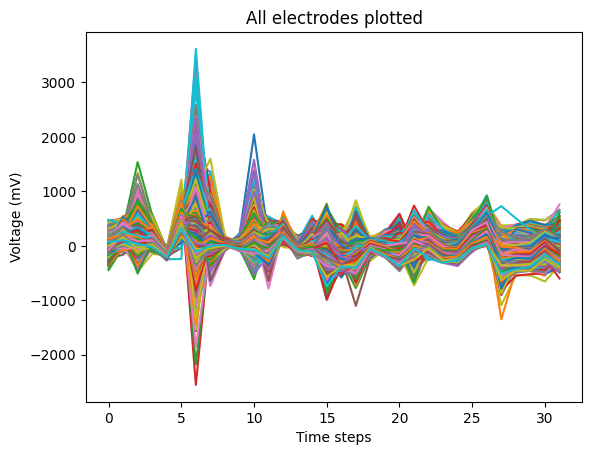

In [27]:
data = torch.Tensor(transpose) # graph all spikes
plt.plot(data)
plt.title("All electrodes plotted")
plt.xlabel("Time steps")
plt.ylabel("Voltage (mV)")

Text(0, 0.5, 'Voltage (mV)')

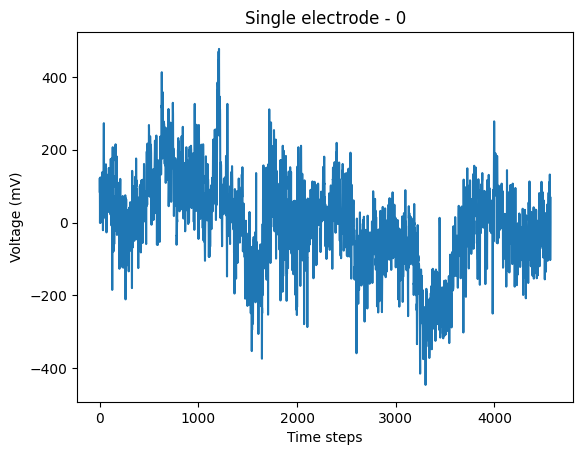

In [28]:
one_spike = torch.Tensor(transpose[0]) # graph all spikes
plt.plot(one_spike)
plt.title("Single electrode - 0")
plt.xlabel("Time steps")
plt.ylabel("Voltage (mV)")

### Deciding threshold for One Electrode

In [29]:
# related noise value and average
# consider varying noise paying attention to picking up/ staying still
# options for threshold:
# - consider st dev
# - break up data into time deltas
# - come back to later
# - neuron refraction
avg_threshold = np.median(transpose[0])
print(avg_threshold)

3.0


### Encode Data for One Electrode

In [30]:
spike_data = spikegen.delta(one_spike, threshold=avg_threshold, off_spike=True)
print(spike_data)



tensor([ 1.,  1., -1.,  ...,  1.,  1.,  1.])


4570


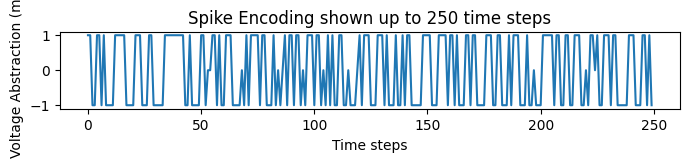

In [31]:
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)
# splt.raster(spike_data, ax, c="black")
# plt.title("Input Neuron for first 100 time steps")
# plt.xlabel("Time step")
# plt.yticks([])
# plt.xlim(0, 100) # go up to transpose.shape[1]
# plt.show()
print(len(spike_data.numpy()))

time_step = 250
plt.title(f"Spike Encoding shown up to {time_step} time steps")
plt.xlabel("Time steps")
plt.ylabel("Voltage Abstraction (mV)")
plt.plot(spike_data.numpy()[:time_step])
plt.show()

In [11]:
print("min :", np.min(spike_data.numpy()))
print("max :", np.max(spike_data.numpy()))

min : -1.0
max : 1.0


### Encode Data for all Electrodes in this Series

In [12]:
all_encoded_series = []
for i,electrode in enumerate(transpose): # for each electrode in the transposed array
    avg_threshold = np.median(transpose[i])
    this_spike = torch.Tensor(transpose[i]) # graph all spikes
    # encoded + converted to numpy
    encoded_electrode_data = spikegen.delta(this_spike, threshold=avg_threshold, off_spike=True).numpy()
    all_encoded_series.append(encoded_electrode_data)

In [13]:
print(len(all_encoded_series), len(all_encoded_series[0]))

32 4570


(32, 4570)
12 100
(12, 100)
(100, 12)


Text(0.5, 1.0, 'Spike Encoding shown up to 100 time steps')

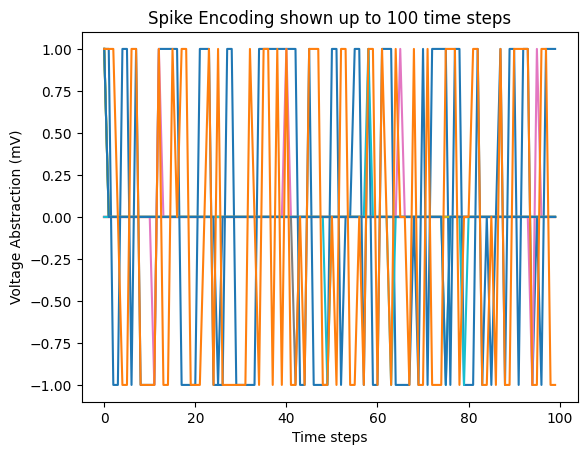

In [14]:
num_electrodes = 12
time_step = 100
nparr = np.array(all_encoded_series)
print(nparr.shape)
arr = nparr[0:num_electrodes,0:time_step]
print(len(arr), len(arr[0]))


plot_this = torch.Tensor(arr)

a = plot_this.numpy()
print(a.shape)
transpose = np.transpose(a)
print(transpose.shape)

plt.xlabel("Time steps")
plt.ylabel("Voltage Abstraction (mV)")
plt.plot(transpose)
plt.title(f"Spike Encoding shown up to {time_step} time steps")

# for electrode_id in range(num_electrodes):
# fig = plt.figure(facecolor="w", figsize=(8,1))
# graph_num = 111
# ax = fig.add_subplot(graph_num)
# plt.title(f"Spike Encoding for electrode 1 shown up to {time_step} time steps")
# plt.xlabel("Time steps")
# plt.ylabel("Voltage Abstraction (mV)")
# plt.plot(arr[0])

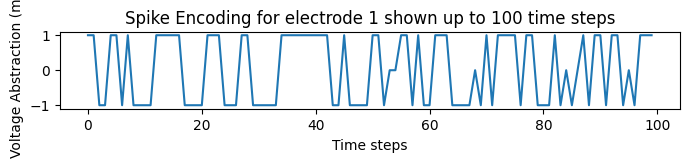

In [15]:
fig = plt.figure(facecolor="w", figsize=(8,1))
graph_num = 111
ax = fig.add_subplot(graph_num)
plt.title(f"Spike Encoding for electrode 1 shown up to {time_step} time steps")
plt.xlabel("Time steps")
plt.ylabel("Voltage Abstraction (mV)")
plt.plot(arr[0])

In [16]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

In [17]:
all_encoded_series[0]

array([ 1.,  1., -1., ...,  1.,  1.,  1.], shape=(4570,), dtype=float32)

# Make Model

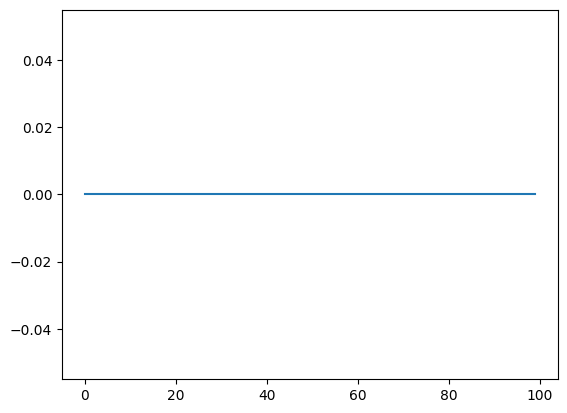

In [18]:
# for i in arr:
#     print(i)

# R = 50M amps and C = 100pF (tao = 5ms)
def leaky_integrate_neuron(U, time_step=1e-3, I=0, R=5e7, C=1e-10):
  tau = R*C
  U = U + (time_step/tau)*(-U + I*R)
  return U

num_steps = 100
U = 0
U_trace = [] # keeps a record of U for plotting

for step in range(num_steps):
  U_trace.append(U)
  U = leaky_integrate_neuron(U) # solve for next step of U

ax = fig.add_subplot(graph_num)
plt.plot(U_trace)


In [19]:
def leaky_integrate_and_fire(mem, cur=0, threshold=1, time_step=1e-3, R=5.1,C=5e-3):
    tau_mem = R*C
    spk = (mem > threshold) # if membrane exceeds threshold, spk=1, else, 0
    mem = mem + (time_step/tau_mem)*(-mem + cur*R)
    return mem, spk

# Lapicque: Without Stimulus

In [20]:
time_step = 1e-3 # delta t
R = 5 # resistance 
C = 1e-3 # current 

lif1 = snn.Lapicque(R=R, C=C, time_step=time_step)

size = 1
mem = torch.ones(size) * .9            # U = 0.9 --> membrane potential initialized to 0.9 
# REPLACE BELOW W SPIKE ENCODED DATA
cur_in = torch.zeros(num_steps, 1)     # I=0 for all t (input is all 0, no input spikes) --> num_steps; 1 stands for dimensionality (will be 2D list with num_steps arrays with 0 as ele)
# OUR DATA
our_data = all_encoded_series[0]
cur_in = [] # converting to prior format
for i in our_data:
    cur_in.append([i])
cur_in = torch.from_numpy(np.array(cur_in))
# cur_in = torch.cat((torch.zeros(10, 1), torch.ones(190, 1)*0.1), 0)  # input current turns on at t=10
# cur_in = torch.cat((torch.zeros(10, 1), torch.ones(20, 1)*(0.1), torch.zeros(170, 1)), 0)  # input turns on at t=10, off at t=30

spk_out = torch.zeros(size)            # output spikes should be 0

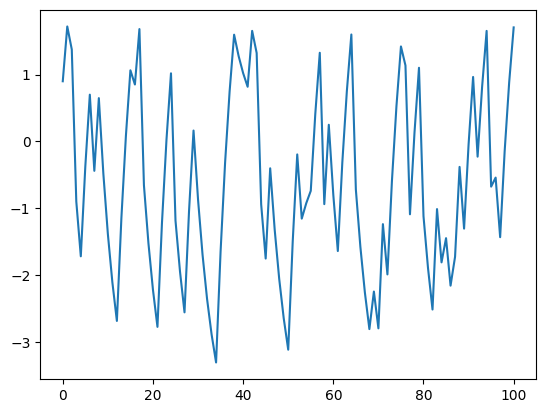

In [21]:
mem_rec = [mem] # list to store recordings of membrane potentials

for step in range(num_steps): # for each step
  spk_out, mem = lif1(cur_in[step], mem) # get whether there was a spike & new membrane potential from lif1
  # Store recordings of membrane potential
  mem_rec.append(mem)
# convert the list of tensors into one tensor
mem_rec = torch.stack(mem_rec)
# pre-defined plotting function
ax = fig.add_subplot(graph_num)

plt.plot(mem_rec)

remove artefacts (blinking, eye movement) ?

# Adding Fire/ Neuron Output Signal Functionality

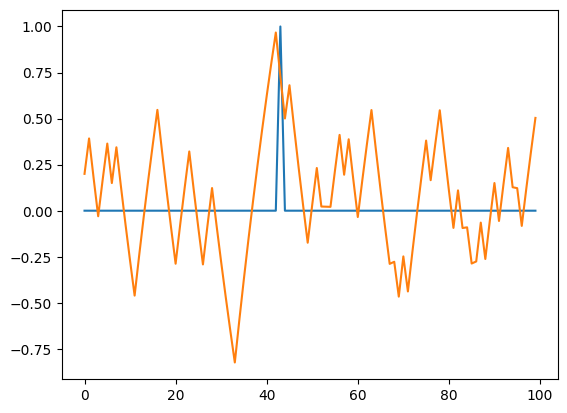

In [22]:
our_data = all_encoded_series[0]
cur_in = [] # converting to prior format
for i in our_data:
    cur_in.append([i])
cur_in = torch.from_numpy(np.array(cur_in))

mem = torch.zeros(1)

# keep track
mem_rec = []
spk_rec = []

threshold = 0.8
# LFI
for step in range(num_steps):
  mem, spk = leaky_integrate_and_fire(mem, cur_in[step], threshold=threshold)
  mem_rec.append(mem)
  spk_rec.append(spk)

# torchify
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

ax = fig.add_subplot(graph_num)
plt.plot(spk_rec)
plt.plot(mem_rec)

In [33]:
len(all_encoded_series)

32

# tutorial

In [34]:
!pip install mne

  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.4.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.4.26-py3-none-any.whl.metadata (2.5 kB)
   ---------------------------------------- 0.0/7.4 MB ? eta -:--:--
   -- ------------------------------------- 0.5/7.4 MB 2.9 MB/s eta 0:00:03
   ----- ---------------------------------- 1.0/7.4 MB 2.7 MB/s eta 0:00:03
   --------- ------------------------------ 1.8/7.4 MB 2.8 MB/s eta 0:00:02
   ------------ --------------------------- 2.4/7.4 MB 2.8 MB/s eta 0:00:02
   --------------- ------------------------ 2.9/7.4 MB 2.8 MB/s eta 0:00:02
   ------------------ --------------------- 3.4/7.4 MB 2.8 MB/s eta 0:00:02
   --------------------- -----


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Parsing New Dataset (with rest baseline)

In [138]:
import mne 
import pandas as pd
def parse_data(filename):
    edf = mne.io.read_raw_edf(filename, preload=True, stim_channel=None)
    events, event_id = mne.events_from_annotations(edf)
    data, times = edf.get_data(return_times=True)
    epochs = mne.Epochs(edf,events, event_id=event_id, baseline=(0,0), tmin=0.0, tmax=0.0)
    x = epochs.get_data()
    y = epochs.events[:, 2]
    # data.shape
    t0 = []
    t1 = []
    t2 = []

    i=0
    while i < len(epochs.events)-1:
        row = epochs.events[i]
        row2 = epochs.events[i+1]
        timestamp1 = row[0]
        timestamp2 = row2[0]
        label = row[2]
        
        chunk = data[timestamp1:timestamp2]

        if label == 1:
            t0.append(chunk)
        elif label == 2:
            t1.append(chunk)
        else:
            t2.append(chunk)
        i+=1    
        
    last = epochs.events[-1]
    timestamp = last[0]
    label = last[2]

    chunk = data[timestamp:]
    if label == 1:
        t0.append(chunk)
    elif label == 2:
        t1.append(chunk)
    else:
        t2.append(chunk)
    features = t0 + t1 + t2
    labels = [0]*len(t0) + [1]*len(t1) + [2]*len(t2)
    return {'features': features, 'labels':labels}

# edf.plot(n_channels=64, duration=20, scalings='auto')

In [136]:
class CustomDataset():
    def __init__(self, labels, features, transform=None):
        # with open(csv_file,"r") as f:
        #     self.data = pd.read_csv(f) # read the files

        # need to be in pandas format?
        self.labels =labels # set the first line of the input data as the label (Originally 1 or 2, but we -1 here so they become 0 or 1)
        self.features = features # set the rest of the input data as the feature (FLUX over time)

        # what is below
        self.transform = transform # transformation (which is None) that will be applied to samples.

        # If you want to have a look at how does this dataset look like with pandas,
        # you can enable the line below.
        # print(data.head(5))

    def __len__(self): # function that gives back the size of the dataset (how many samples)
        return len(self.labels)

    def __getitem__(self, idx): # retrieves a data sample from the dataset
        label = self.labels[idx] # fetch label of sample
        feature = self.features[idx] # fetch features of sample

        if self.transform: # if there is a specified transformation, transform the data
            feature = self.transform(feature)

        sample = {'feature': feature, 'label': label}
        return sample

In [ ]:
res = parse_data('S001R03.edf')
res2 = parse_data('S001R03.edf')

d = CustomDataset(features, labels)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (30,) + inhomogeneous part.